# Import libraries, set config

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

import lightgbm as lgb

from eli5.sklearn import PermutationImportance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss, precision_score

from colorama import Style, Fore
from time import sleep

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators


class CFG:
    load = True
    historical = False
    create_dataset = True
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.031
    ttype = 'both'
    patterns_to_filter = ['MACD_Volume24']
    select_features = False
    train_NN = False
    train_LGBM = True
    n_repeats = 1
    n_folds = 5
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load MACD buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['MACD', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'MACD': {
                          "fastperiod": [14],
                          "slowperiod": [28],
                          "signalperiod": [11]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

Timeframe is 1h/4h, trade type is buy
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]


Load the datasets...
ByBitPerpetual
1000000VINUUSDT
10000LADYSUSDT
10000NFTUSDT
10000SATSUSDT
10000STARLUSDT
1000BONKUSDT
1000BTTUSDT
1000FLOKIUSDT
1000LUNCUSDT
1000PEPEUSDT
1000RATSUSDT
1000XECUSDT
1CATUSDT
1INCHUSDT
AAVEUSDT
ACEUSDT
ACHUSDT
ADAUSDT
AERGOUSDT
AGIUSDT
AGIXUSDT
AGLDUSDT
AKROUSDT
ALGOUSDT
ALICEUSDT
ALPACAUSDT
ALPHAUSDT
AMBUSDT
ANKRUSDT
ANTUSDT
APEUSDT
API3USDT
APTUSDT
ARBUSDT
ARKMUSDT
ARKUSDT
ARPAUSDT
ARUSDT
ASTRUSDT
ATAUSDT
ATOMUSDT
AUCTIONUSDT
AUDIOUSDT
AVAXUSDT
AXLUSDT
AXSUSDT
BADGERUSDT
BAKEUSDT
BALUSDT
BANDUSDT
BATUSDT
BCHUSDT
BEAMUSDT
BELUSDT
BICOUSDT
BIGTIMEUSDT
BLURUSDT
BLZUSDT
BNBUSDT
BNTUSDT
BNXUSDT
BOBAUSDT
BONDUSDT
BSVUSDT
BSWUSDT
BTCUSDT
C98USDT
CAKEUSDT
CEEKUSDT
CELOUSDT
CELRUSDT
CFXUSDT
CHRUSDT
CHZUSDT
CKBUSDT
COMBOUSDT
COMPUSDT
COREUSDT
COTIUSDT
CROUSDT
CRVUSDT
CTCUSDT
CTKUSDT
CTSIUSDT
CVCUSDT
CVXUSDT
CYBERUSDT
DARUSDT
DASHUSDT
DATAUSDT
DENTUSDT
DGBUSDT
DODOUSDT
DOGEUSDT
DOTUSDT
DUSKUSDT
DYDXUSDT
EDUUSDT
EGLDUSDT
ENJUSDT
ENSUSDT
EOSUSDT
ETCUSDT
ETHUSDT
E

100%|██████████| 1/1 [33:00<00:00, 1980.62s/it]


,pattern,MACD_fastperiod,MACD_slowperiod,MACD_signalperiod,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,MACD_Volume24,14,28,11,1.8949,2.5575,3.053,3.042,2.9438,2.8541,2.7785,2.738,2.7337,2.7216,2.6888,2.6399,2.6176,2.6049,2.5853,2.5575,2.5446,2.5329,2.5099,2.4953,2.478,2.458,2.4334,2.4199,0.27,0.56,0.87,1.16,1.46,1.74,2.02,2.31,2.58,2.85,3.11,3.37,3.61,3.85,4.08,4.29,4.49,4.67,4.83,4.97,5.08,5.17,5.24,5.28,8202


# Load MACD sell data

In [3]:
ttype = 'sell'
pattern = ['MACD', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'MACD': {
                          "fastperiod": [14],
                          "slowperiod": [28],
                          "signalperiod": [11]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml')
  display(stat)

Timeframe is 1h/4h, trade type is sell
Number of combinations is 1


100%|██████████| 1/1 [09:00<00:00, 540.02s/it]


,pattern,MACD_fastperiod,MACD_slowperiod,MACD_signalperiod,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,MACD_Volume24,14,28,11,1.5016,1.7557,1.9734,1.9132,1.8278,1.7484,1.6977,1.6404,1.5967,1.5638,1.5462,1.5013,1.4674,1.4404,1.4256,1.3883,1.3591,1.3328,1.3177,1.2914,1.2714,1.2542,1.2373,1.2157,-0.22,-0.44,-0.68,-0.92,-1.16,-1.39,-1.63,-1.86,-2.09,-2.32,-2.55,-2.76,-2.98,-3.18,-3.38,-3.56,-3.72,-3.87,-4.0,-4.11,-4.21,-4.3,-4.39,-4.43,15707


# Check if all dataframes has data for both timeframes 1h and 4h

In [4]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare data

In [5]:
# Get configs
configs = ConfigFactory.factory(environ).configs

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add RSI
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add Volume24
    vol24 = indicators.Volume24(ttype, configs)
    df = vol24.get_indicator(df, '', '1h', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    # df = macd.get_indicator(df, '', '', 0)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    # df = trend.get_indicator(df, '', '', 0)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 
                        'macd_dir', 'macdsignal', 'macdsignal_dir']
    # merge higher timeframe indicators with working timeframe
    df = pd.merge(df, df_higher[higher_features], how='left', on='time')
    df.ffill(inplace=True)
    df = df.dropna()
    return df.reset_index(drop=True)

def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + step, step):
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, :].reset_index(drop=True)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'close']

            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                time_next = t + timedelta(hours=i)
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                target_buy_tp = 1 if target_buy > close_price * CFG.cls_target_ratio_tp else 0
                target_buy_sl = 1 if target_buy > close_price * CFG.cls_target_ratio_sl else 0
                target_sell_tp = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_tp) else 0
                target_sell_sl = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_sl) else 0
                
                # set sl flag if price goes through stop-loss threshold before it goes through take-profit threshold
                if (row['ttype'].values[0] == 'buy' and target_sell_sl == 1) or (row['ttype'].values[0] == 'sell' and target_buy_sl == 1):
                    break
                
                if (row['ttype'].values[0] == 'buy' and target_buy_tp == 1) or (row['ttype'].values[0] == 'sell' and target_sell_tp == 1):
                    row['target'] = 1
                    break
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    return train_df

if CFG.create_dataset:
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()

    # Sell
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()

    train_buy = pd.concat([train_buy, train_sell[train_sell['ttype'] == 'buy']]).sort_values('time').reset_index(drop=True)
    train_sell = pd.concat([train_sell, train_buy[train_buy['ttype'] == 'sell']]).sort_values('time').reset_index(drop=True)

    train_buy = train_buy[train_buy['ttype'] == 'buy']
    train_sell = train_sell[train_sell['ttype'] == 'sell']

    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # display(df.head())
    # display(df.shape)


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/763 [00:00<?, ?it/s]

# Check pattern / target distribution

In [6]:
# ticker num for buy/sell: 681/750
if CFG.create_dataset:
    display(train_buy['ttype'].value_counts()) # 7849
    display(train_sell['ttype'].value_counts()) # 15045
    display(train_buy[['target', 'pattern']].value_counts()) # 4940 / 2909
    display(train_sell[['target', 'pattern']].value_counts()) # 8366 / 6679

buy    7855
Name: ttype, dtype: int64

sell    15061
Name: ttype, dtype: int64

target  pattern      
1       MACD_Volume24    5020
0       MACD_Volume24    2835
dtype: int64

target  pattern      
1       MACD_Volume24    8522
0       MACD_Volume24    6539
dtype: int64

# Check target corectness

In [7]:
# i = 557

# x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
# y = x.iloc[i]
# low_price, high_price = y['close'] / CFG.cls_target_ratio_tp, y['close'] * CFG.cls_target_ratio_tp,
# print(y['ticker'], y['time'], y['ttype'], y['target'])

# tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}-SWAP_4h.pkl')

# tmp_df_1h['low_price'] = low_price
# tmp_df_1h['high_price'] = high_price
# idx = tmp_df_1h[tmp_df_1h['time'] == y['time']].index[0]

# tmp_df_1h = tmp_df_1h.iloc[idx:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]

# if y['ttype'] == 'buy':
#     tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
# else:
#     tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']

# tmp_df_1h

# Compare indicator values for bot and optimizer

In [8]:
# import pandas as pd

# ttype = 'buy'
# timeframe = '4h'
# ticker = '1INCHUSDT'
# configs = ConfigFactory.factory(environ).configs

# # x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_{timeframe}_{ttype}_12_28_0.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# x = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# y = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add RSI
# rsi = indicators.RSI(ttype, configs)
# x = rsi.get_indicator(x, '', '', 0)
# # add STOCH
# stoch = indicators.STOCH(ttype, configs)
# x = stoch.get_indicator(x, '', '', 0)
# # add ATR
# atr = indicators.ATR(ttype, configs)
# x = atr.get_indicator(x, '', '', 0)
# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)
# # add MACD
# macd = indicators.MACD(ttype, configs)
# y = macd.get_indicator(y, '', '', 0)

# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']

# higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir',
#                            'macdsignal', 'macdsignal_dir']
# x[higher_features] = pd.merge(x[['time']], y[higher_features], how='left', on='time')
# x.ffill(inplace=True)
# x.dropna(inplace=True)
# x.reset_index(drop=True, inplace=True)

# x[cols].tail(10)

# Check buy trades correctness

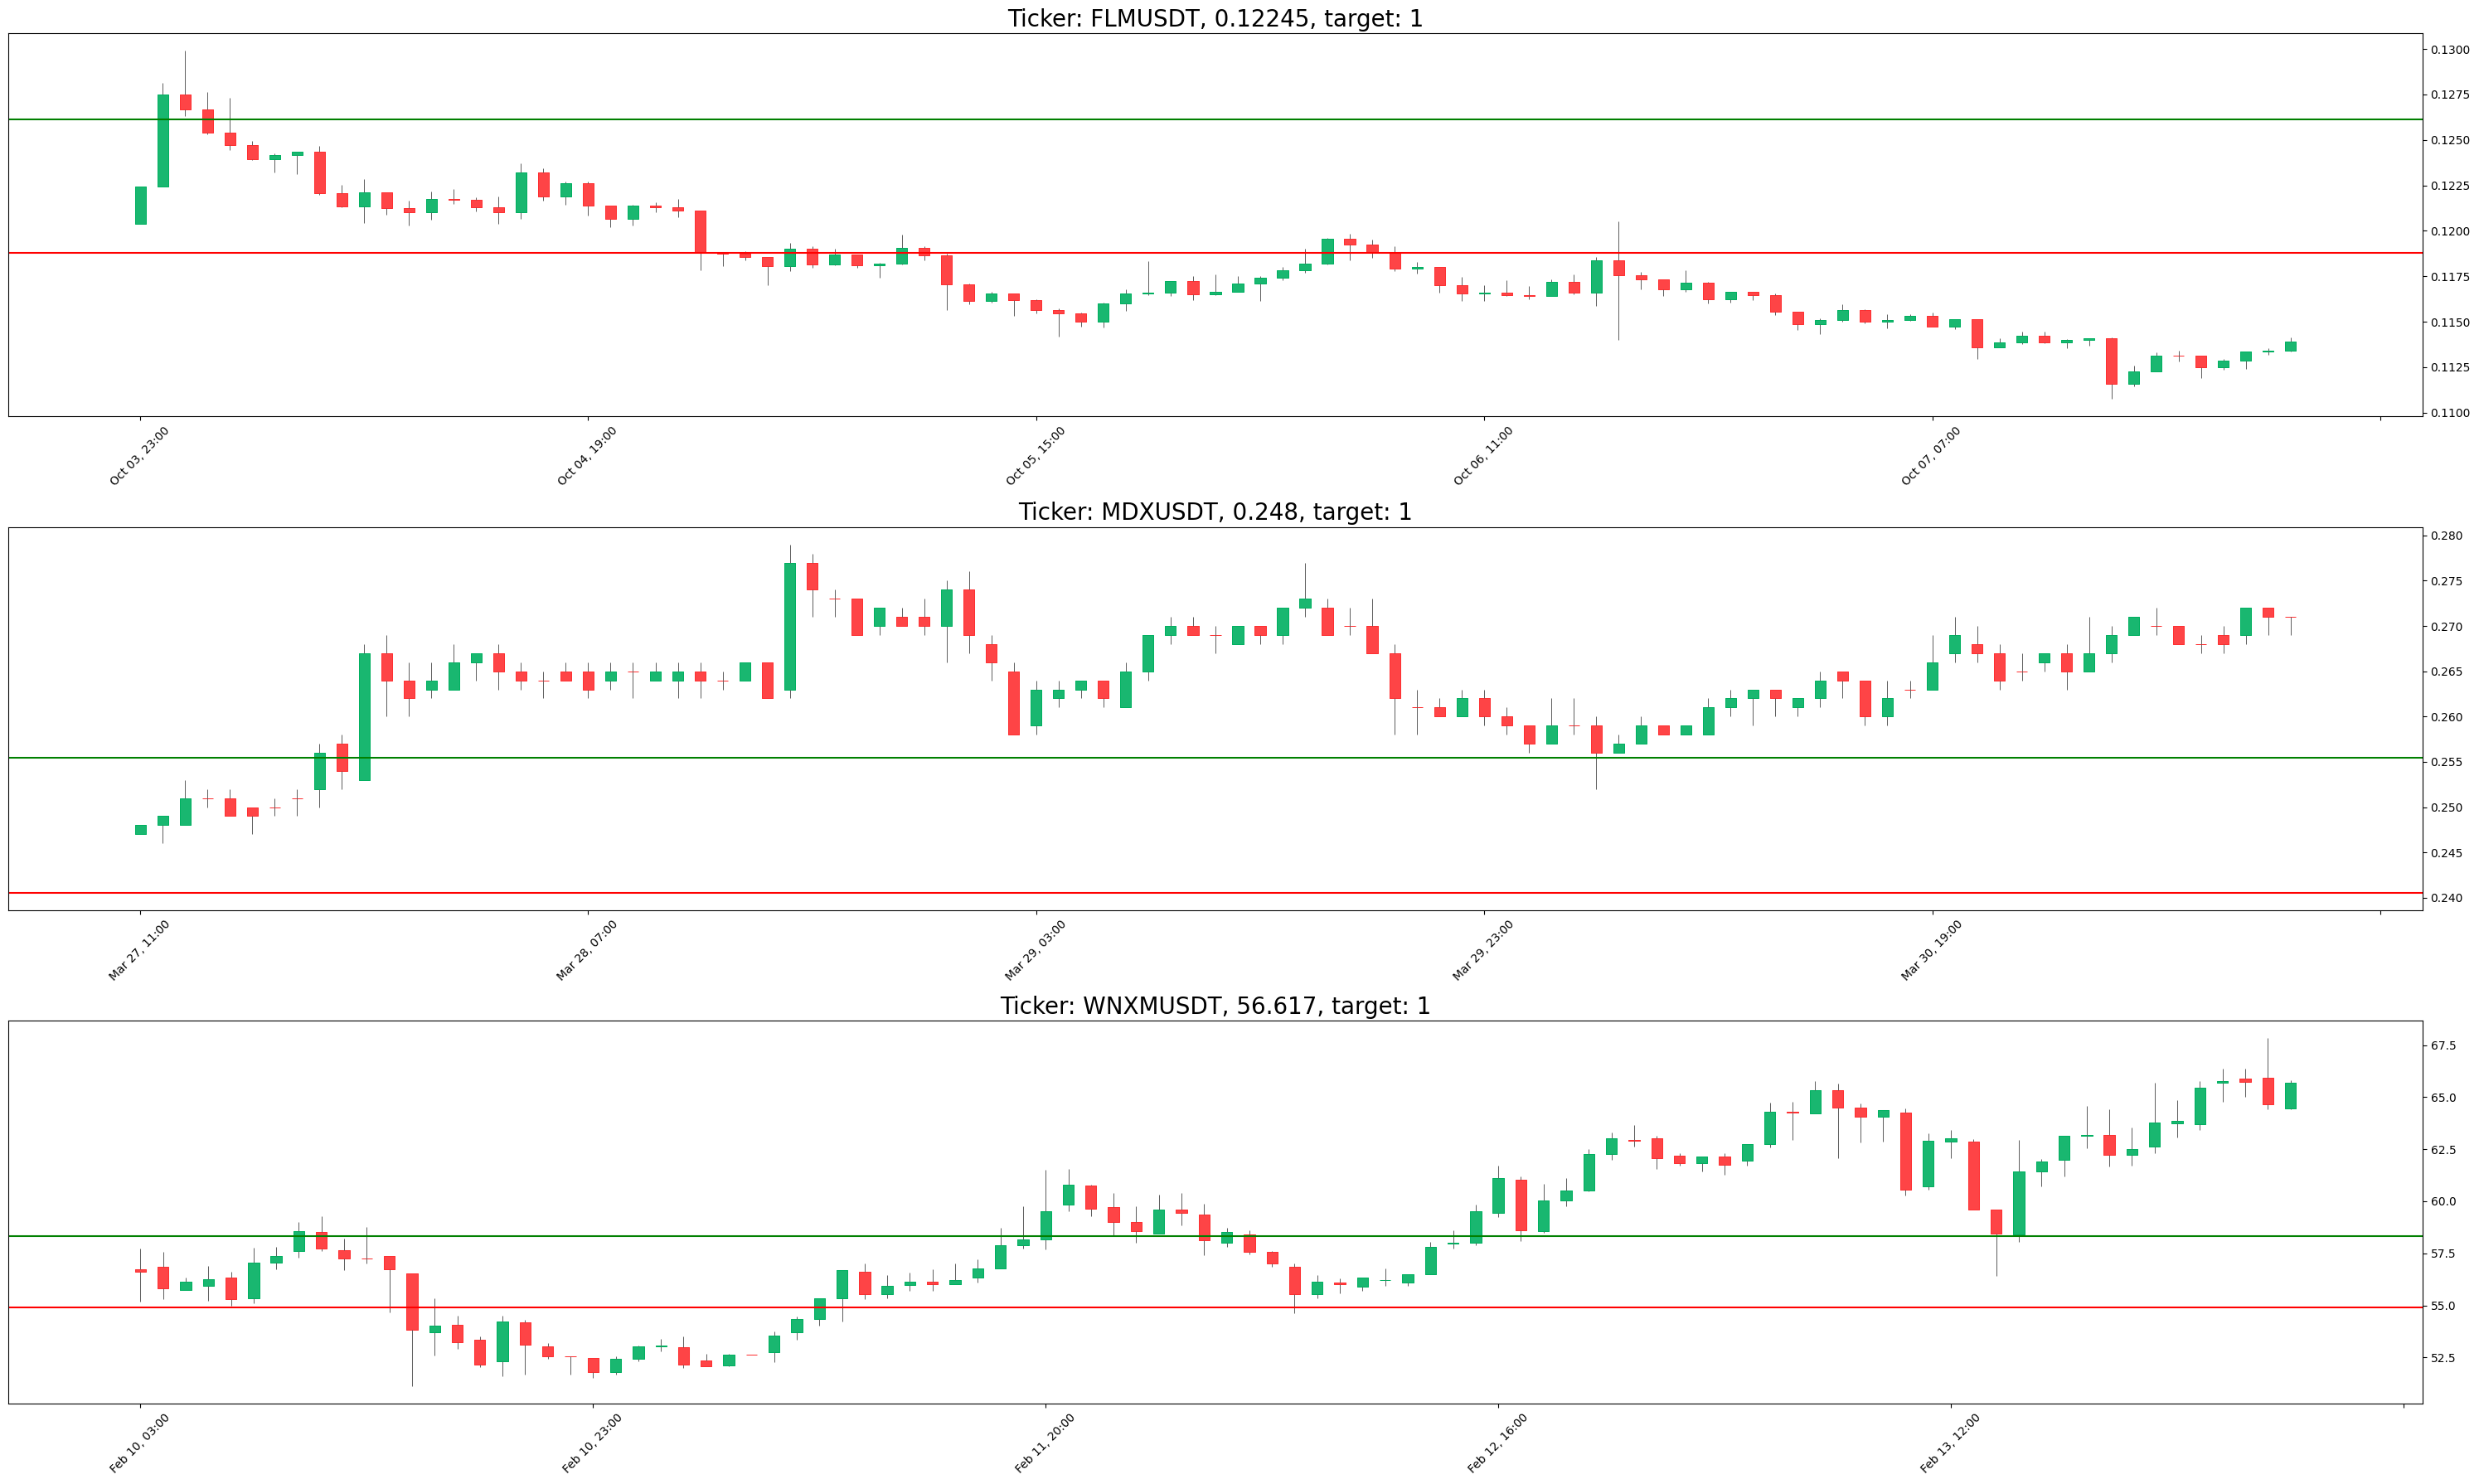

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        price = row['close']
        target = row['target']
        ttype = row['ttype']

        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)
        
        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, {price}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Check sell trades correctness

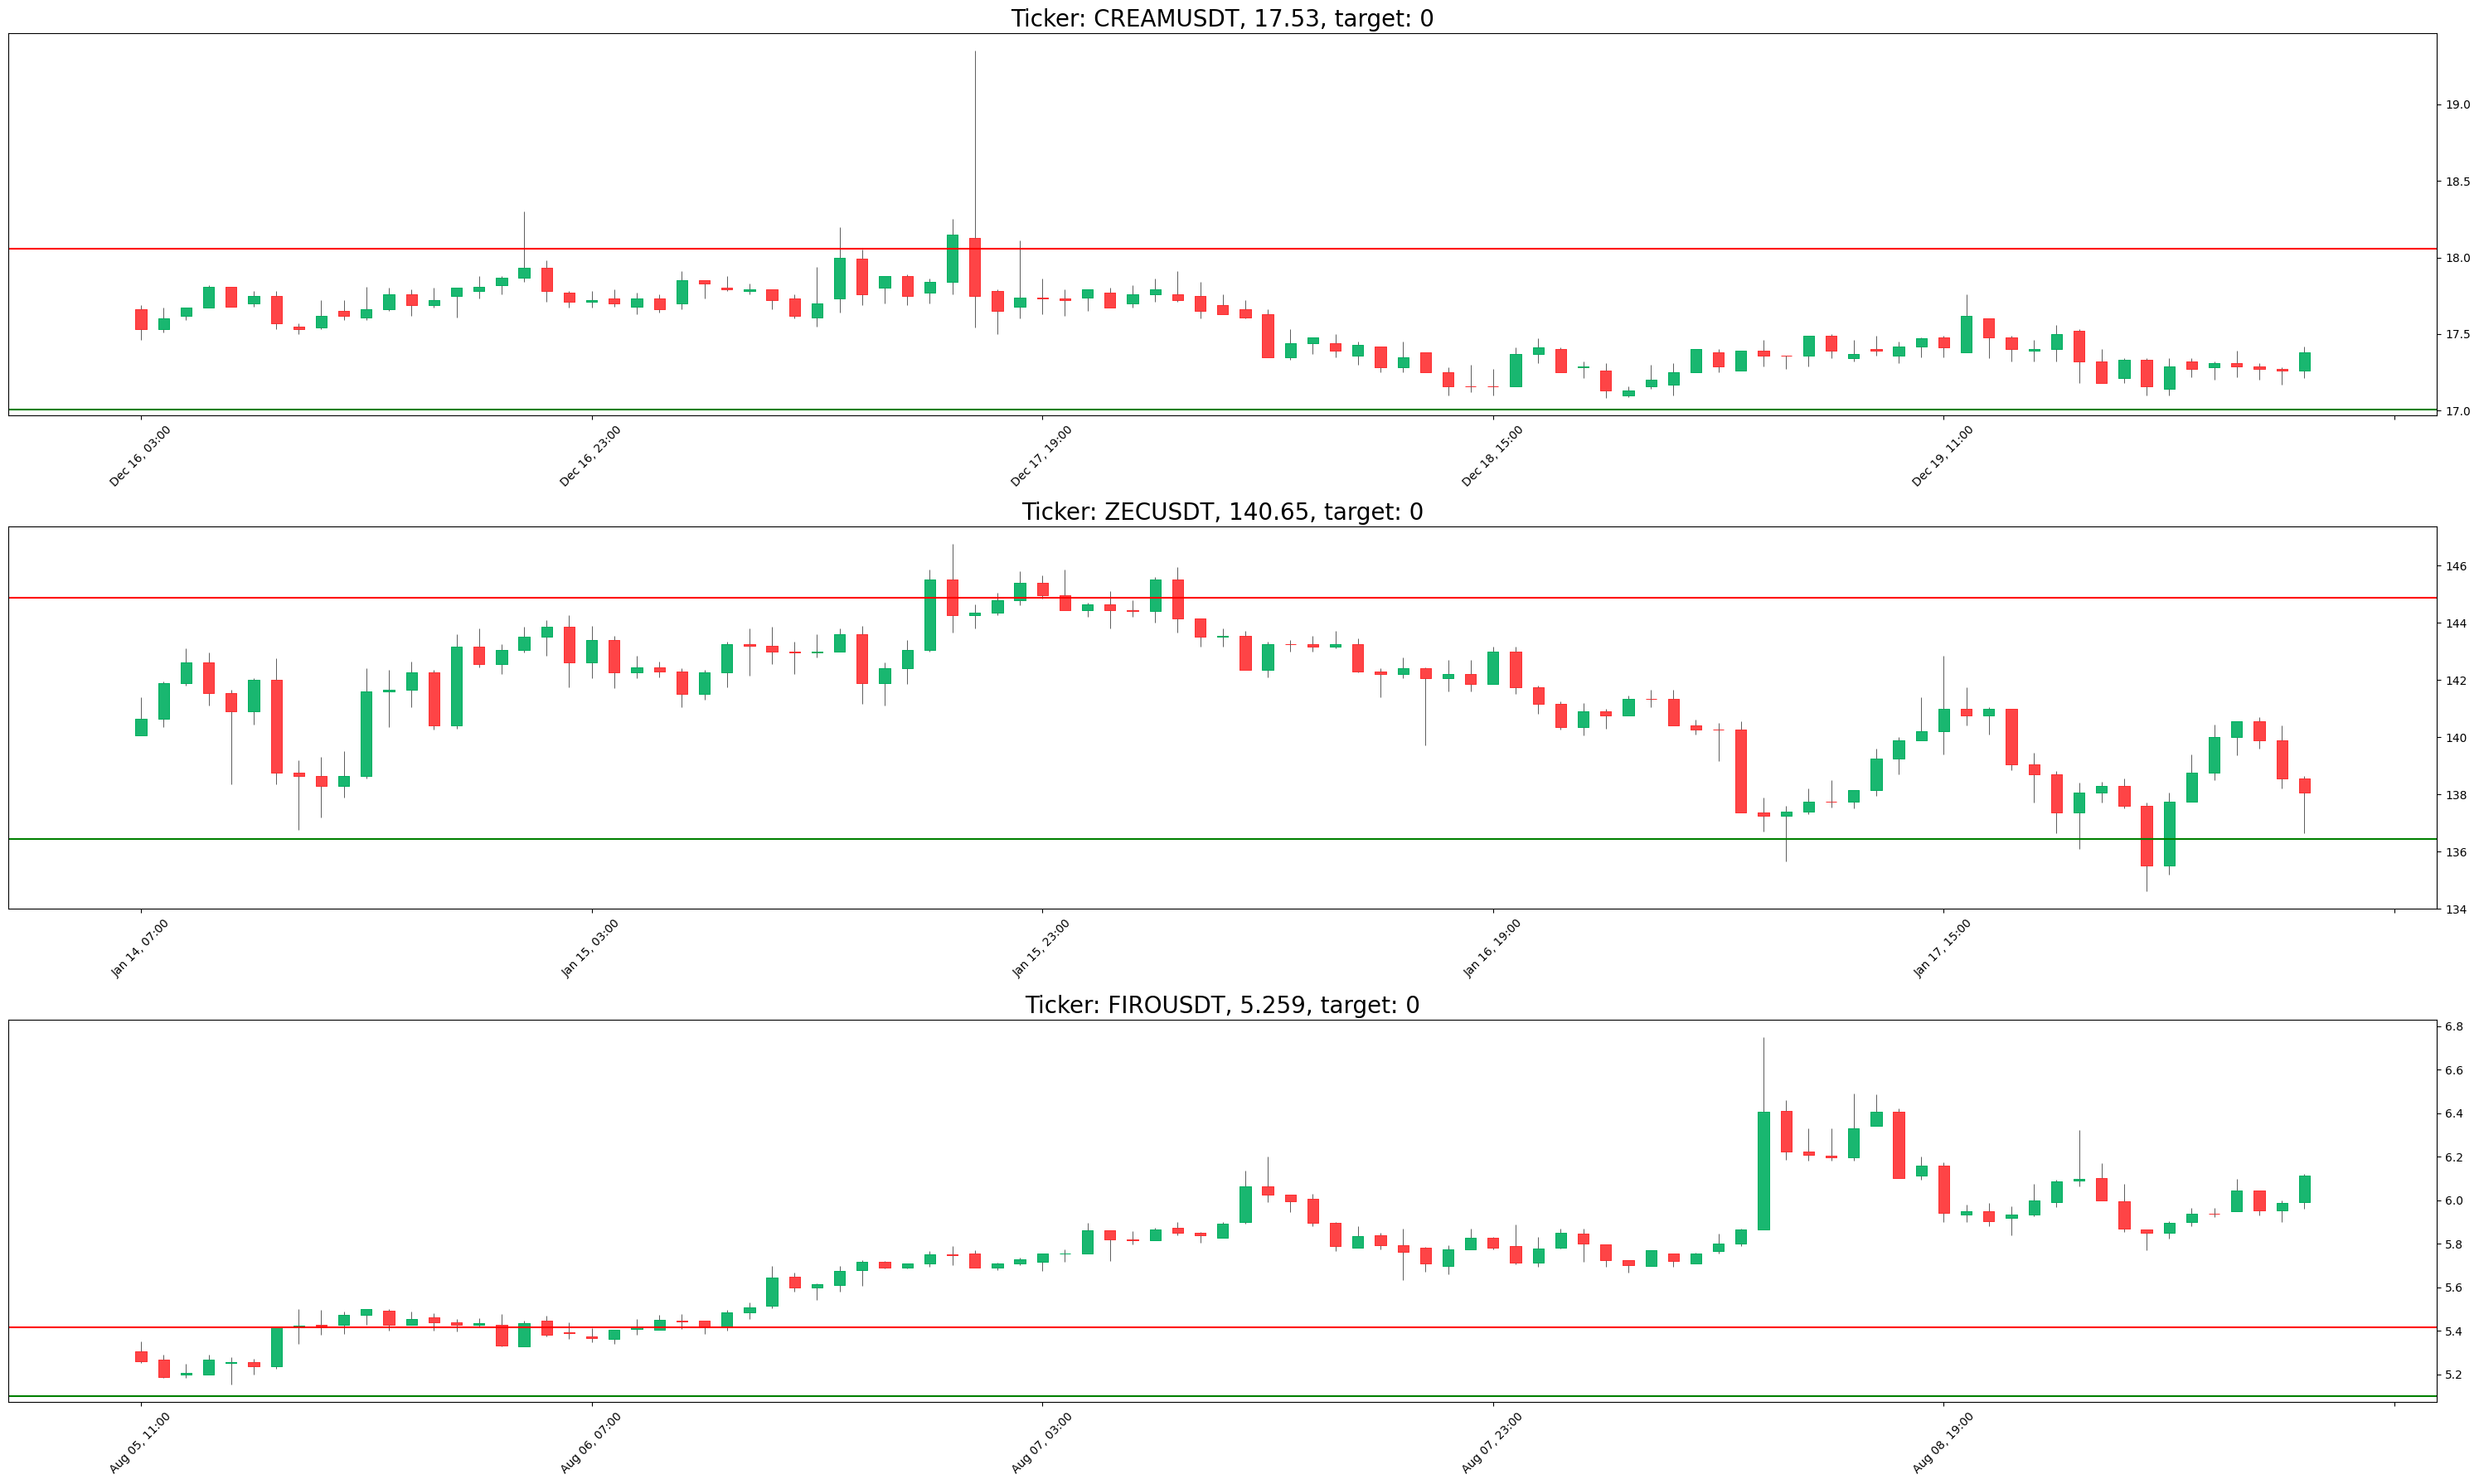

In [10]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        price = row['close']
        target = row['target']
        ttype = row['ttype']

        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)
        
        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, {price}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Concat buy and sell datasets

,time,open,high,low,close,volume,rsi,stoch_slowk,stoch_slowd,stoch_slowk_dir,stoch_slowd_dir,stoch_diff,atr,close_smooth,volume_24,linear_reg,linear_reg_angle,macd,macdhist,macd_dir,macdsignal,macdsignal_dir,open_prev_4,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_slowk_dir_prev_4,stoch_slowd_dir_prev_4,stoch_diff_prev_4,atr_prev_4,close_smooth_prev_4,volume_24_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macd_dir_prev_4,macdsignal_prev_4,macdsignal_dir_prev_4,ticker,pattern,open_prev_8,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_slowk_dir_prev_8,stoch_slowd_dir_prev_8,stoch_diff_prev_8,atr_prev_8,close_smooth_prev_8,volume_24_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macd_dir_prev_8,macdsignal_prev_8,macdsignal_dir_prev_8,open_prev_12,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_slowk_dir_prev_12,stoch_slowd_dir_prev_12,stoch_diff_prev_12,atr_prev_12,close_smooth_prev_12,volume_24_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macd_dir_prev_12,macdsignal_prev_12,macdsignal_dir_prev_12,open_prev_16,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_slowk_dir_prev_16,stoch_slowd_dir_prev_16,stoch_diff_prev_16,atr_prev_16,close_smooth_prev_16,volume_24_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macd_dir_prev_16,macdsignal_prev_16,macdsignal_dir_prev_16,open_prev_20,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_slowk_dir_prev_20,stoch_slowd_dir_prev_20,stoch_diff_prev_20,atr_prev_20,close_smooth_prev_20,volume_24_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macd_dir_prev_20,macdsignal_prev_20,macdsignal_dir_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_slowk_dir_prev_24,stoch_slowd_dir_prev_24,stoch_diff_prev_24,atr_prev_24,close_smooth_prev_24,volume_24_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macd_dir_prev_24,macdsignal_prev_24,macdsignal_dir_prev_24,open_prev_28,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_slowk_dir_prev_28,stoch_slowd_dir_prev_28,stoch_diff_prev_28,atr_prev_28,close_smooth_prev_28,volume_24_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macd_dir_prev_28,macdsignal_prev_28,macdsignal_dir_prev_28,open_prev_32,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_slowk_dir_prev_32,stoch_slowd_dir_prev_32,stoch_diff_prev_32,atr_prev_32,close_smooth_prev_32,volume_24_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macd_dir_prev_32,macdsignal_prev_32,macdsignal_dir_prev_32,open_prev_36,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_slowk_dir_prev_36,stoch_slowd_dir_prev_36,stoch_diff_prev_36,atr_prev_36,close_smooth_prev_36,volume_24_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macd_dir_prev_36,macdsignal_prev_36,macdsignal_dir_prev_36,open_prev_40,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_slowk_dir_prev_40,stoch_slowd_dir_prev_40,stoch_diff_prev_40,atr_prev_40,close_smooth_prev_40,volume_24_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macd_dir_prev_40,macdsignal_prev_40,macdsignal_dir_prev_40,open_prev_44,high_prev_44,low_prev_44,close_prev_44,volume_prev_44,rsi_prev_44,stoch_slowk_prev_44,stoch_slowd_prev_44,

<AxesSubplot:>

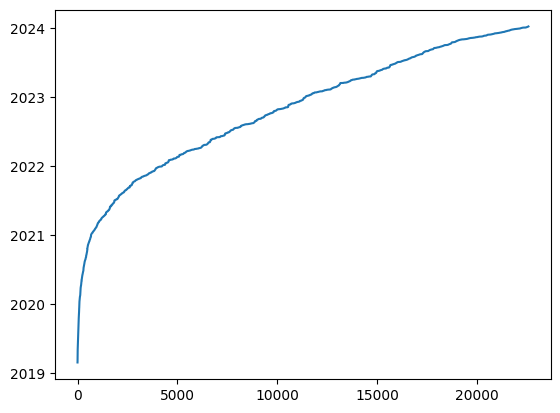

In [11]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

if CFG.ttype == 'both':
    df_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
    df_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
    df = pd.concat([df_buy, df_sell])
elif CFG.ttype == 'buy':
    df = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
else:
    df = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')


df = df[df['pattern'].isin(CFG.patterns_to_filter)]
df = df[df['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]

df = df.sort_values('time')
# do not consider the last signals - they may contain erroneus signals
df = df[df['time'] < df['time'].max()].reset_index(drop=True)
train_df = df

display(df)
df['time'].plot()


# Check the last signals

In [12]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
y = x[~x['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]
display(y.shape)
x = x[x['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]
x[['time', 'ticker', 'ttype']].tail(50)

(367, 79)

,time,ticker,ttype
23859,2024-01-07 15:00:00,SANTOSUSDT,sell
23860,2024-01-07 19:00:00,FORUSDT,sell
23861,2024-01-07 19:00:00,PROPSUSDT,buy
23862,2024-01-07 19:00:00,DOCKUSDT,sell
23863,2024-01-07 19:00:00,VIBUSDT,sell
23864,2024-01-07 19:00:00,POWRUSDT,sell
23865,2024-01-07 19:00:00,ROUTEUSDT,buy
23866,2024-01-07 19:00:00,1INCHUSDT,sell
23867,2024-01-07 23:00:00,FRONTUSDT,sell
23868,2024-01-07 23:00:00,POLYXUSDT,sell


# Select features with BORUTA feature importance

In [13]:
import pandas as pd
import lightgbm as lgb
from shaphypetune import BoostBoruta

if CFG.select_features:

  df.to_csv('df.csv', index=False)
  df_boruta = pd.read_csv('df.csv')
  os.remove('df.csv')
  
  params = {
            'n_estimators': 1000,
            'learning_rate': 0.02,
          #   'early_stopping_round': 100,
            'max_depth': 10,
            'subsample' : 0.7,
            'colsample_bytree': 0.85,
            'num_leaves': 24,
            'verbosity': -1,
            'importance_type': 'gain',
            'max_bin': 255,
            'reg_alpha': 1e-6,
            'reg_lambda': 1e-8
          }

  boruta_df_ = pd.DataFrame()
  features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]

  X, y, time = df_boruta[features], df_boruta['target'], df_boruta['time']

  tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
  eval_metric = 'logloss'

  # Stratify based on Class and Alpha (3 types of conditions)
  for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

      print(f'Fold: {fold}')
      # Split the dataset according to the fold indexes.
      X_train = X.iloc[train_idx]
      X_val = X.iloc[val_idx]
      y_train = y.iloc[train_idx]
      y_val = y.iloc[val_idx]

      clf = lgb.LGBMClassifier(**params)
      model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False)
      model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
              eval_metric='logloss', 
              callbacks=[lgb.log_evaluation(100)])

      boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
      if boruta_df_.shape[0] == 0:
          boruta_df_ = boruta_importance_df.copy()
      else:
          boruta_df_ += boruta_importance_df

  boruta_df_ = boruta_df_.sort_values('importance')
  boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

  del df_boruta

# Select features with permutation importance and GBM feature importance

In [14]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


params = {
          'n_estimators': 1000,
          'learning_rate': 0.02,
        #   'early_stopping_round': 100,
          'max_depth': 9,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-8
        }

task_type = 'cls'

if task_type == 'cls':
    params['boosting_type'] = 'dart'
    params['objective'] = 'binary'
else:
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'

if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(df, permut=True)

# Combine importances and save them

In [15]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance_{CFG.ttype}.csv')
else:
    fi = pd.read_csv(f'feature_importance_{CFG.ttype}.csv')

# Check model predictions

In [97]:
def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    fi = fi['Feature'].head(feature_num)
    feature_dict = defaultdict(list)
    features = list()

    # exclude some features by their numbers
    feature_idx = [i for i in range(feature_num) if i not in features_to_exclude]
    fi = (np.array(fi)[feature_idx])
    
    for f in fi:
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

fi = pd.read_csv(f'feature_importance_{CFG.ttype}.csv')
feature_num = 163
features_to_exclude = []
features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
model = joblib.load('lgbm.pkl')

X = train_df.tail(50)
X['pred'] = model.predict_proba(X[features])[:,1]
# X.loc[X['ticker'] == 'SPACEUSDT', ['time', 'ticker', 'ttype', 'pred']]
X[['time', 'ticker', 'ttype', 'pred']]

,time,ticker,ttype,pred
22142,2023-12-29 23:00:00,SPACEUSDT,sell,0.443190
22405,2024-01-03 19:00:00,SPACEUSDT,sell,0.621491
22461,2024-01-05 03:00:00,SPACEUSDT,buy,0.526877
22502,2024-01-06 07:00:00,SPACEUSDT,sell,0.397603
22539,2024-01-08 03:00:00,SPACEUSDT,sell,0.593526
22568,2024-01-09 03:00:00,SPACEUSDT,buy,0.469055


# Train_test split based on ticker groups

In [17]:
val_idxs = list()
with open(f'bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def model_train(df, train_df, features, task_type, how, n_folds, low_bound, high_bound, train_test): 
    X, time = train_df[features], train_df['time']
    # X = pd.concat([X, pd.get_dummies(train_df[['ttype']], drop_first=True)], axis=1)
    y = train_df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(train_df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(train_df) * 2) // (n_folds * 3))

        print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (train_df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            display(y_val.value_counts())
            display(train_df.loc[val_idx[0], 'time'])
            display(train_df.loc[val_idx[-1], 'time'])
            
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                        eval_metric='logloss')#, callbacks = [lgb.log_evaluation(100)])

            val_preds = model.predict_proba(X_val)
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:,1], low_bound, high_bound)
            print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                  f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n')
            oof[val_idx, 0] = val_preds[:,1]

        return oof, model, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        model = lgb.LGBMClassifier(**params)
        model.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        return np.zeros([df.shape[0], 1]), model, None

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf[oof < low_bound] = 0
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]

    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

train_test = 'fold' # fold, test, full, inference

low_bound, high_bound = 0.32, 0.68
params = {
    'boosting_type': 'dart',
    'n_estimators': 1500,
    'learning_rate': 0.02,
    # 'early_stopping_round': 50,
    'max_depth': 10,
    'colsample_bytree': 0.85,
    'subsample': 0.85,
    'subsample_freq': 1,
    'num_leaves': 23,
    'verbosity': -1,
    'max_bin': 255,
    'reg_alpha': 1e-6,
    'reg_lambda': 1e-7,
    'objective': 'binary',
    # 'is_unbalance': True,
    # 'class_weight': 'balanced',
    'metric': 'average_precision'
    }

if CFG.train_LGBM:
    if train_test != 'inference':
        oof, model, val_idxs = model_train(df, train_df, features, task_type=task_type, how='lgbm', n_folds=5, low_bound=low_bound, high_bound=high_bound, train_test=train_test)
    if train_test == 'fold':
        # fold
        y = train_df['target'][val_idxs]
        oof = oof[val_idxs]
        oof_val_score = log_loss(y, oof)
        oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
        print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
              f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}')
        # feature_exclude_dict[j] = (oof_val_score, oof_conf_prec_score, oof_conf_obj_pct)
    elif train_test == 'full':
        joblib.dump(model, f'lgbm.pkl')
        # save feature dictionary for further inference
        with open(f'features.json', 'w') as f:
            json.dump(feature_dict, f)
    

Training with 163 features
Fold #1


1    4493
0    2906
Name: target, dtype: int64

Timestamp('2022-07-01 03:00:00')

Timestamp('2024-01-09 11:00:00')

Logloss: 0.6422588312974876, Confident objects precision: 0.7412974683544303
Number of confident objects 2528, % of confident objects: 0.34166779294499255

Fold #2


1    3658
0    2391
Name: target, dtype: int64

Timestamp('2022-11-12 23:00:00')

Timestamp('2024-01-09 11:00:00')

Logloss: 0.6364021501531385, Confident objects precision: 0.7536008230452675
Number of confident objects 1944, % of confident objects: 0.3213754339560258

Fold #3


1    2805
0    1737
Name: target, dtype: int64

Timestamp('2023-03-26 03:00:00')

Timestamp('2024-01-09 11:00:00')

Logloss: 0.6256114034545062, Confident objects precision: 0.7817638266068759
Number of confident objects 1338, % of confident objects: 0.29458388375165123

Fold #4


1    1918
0    1162
Name: target, dtype: int64

Timestamp('2023-07-24 19:00:00')

Timestamp('2024-01-09 11:00:00')

Logloss: 0.6231209201232152, Confident objects precision: 0.8155940594059405
Number of confident objects 808, % of confident objects: 0.2623376623376623

Fold #5


1    943
0    518
Name: target, dtype: int64

Timestamp('2023-11-10 23:00:00')

Timestamp('2024-01-09 11:00:00')

Logloss: 0.5912983580906752, Confident objects precision: 0.8621495327102804
Number of confident objects 428, % of confident objects: 0.2929500342231348

Total fold Logloss: 0.6302944488234208, Total confident objects precision: 0.782015065913371
Number of confident objects: 2124, Total % of confident objects: 0.2870658197053656


In [18]:
# Training with 163 features
# Fold #1
# 1    8506
# 0    6422
# Name: target, dtype: int64Timestamp('2022-06-28 11:00:00')Timestamp('2024-01-05 07:00:00')
# Logloss: 0.655924777724041, Confident objects precision: 0.7184191954834157
# Number of confident objects 4251, % of confident objects: 0.28476688102893893

# Fold #2
# 1    6724
# 0    5221
# Name: target, dtype: int64Timestamp('2022-11-12 15:00:00')Timestamp('2024-01-05 07:00:00')
# Logloss: 0.6522018910448946, Confident objects precision: 0.7414486921529175
# Number of confident objects 2982, % of confident objects: 0.24964420259522813

# Fold #3
# 1    5068
# 0    3845
# Name: target, dtype: int64Timestamp('2023-03-23 07:00:00')Timestamp('2024-01-05 07:00:00')
# Logloss: 0.6454714488773095, Confident objects precision: 0.7581417624521073
# Number of confident objects 2088, % of confident objects: 0.23426455738808483

# Fold #4
# 1    3400
# 0    2523
# Name: target, dtype: int64Timestamp('2023-07-20 15:00:00')Timestamp('2024-01-05 07:00:00')
# Logloss: 0.6420531056178669, Confident objects precision: 0.7871649065800163
# Number of confident objects 1231, % of confident objects: 0.20783386797231132

# Fold #5
# 1    1682
# 0    1163
# Name: target, dtype: int64Timestamp('2023-11-08 03:00:00')Timestamp('2024-01-05 07:00:00')
# Logloss: 0.6201886967292256, Confident objects precision: 0.8384491114701131
# Number of confident objects 619, % of confident objects: 0.21757469244288224

# Total fold Logloss: 0.6437283731431884, Total confident objects precision: 0.7745853080568721
# Number of confident objects: 3376, Total % of confident objects: 0.22615219721329047

# Display PR curve

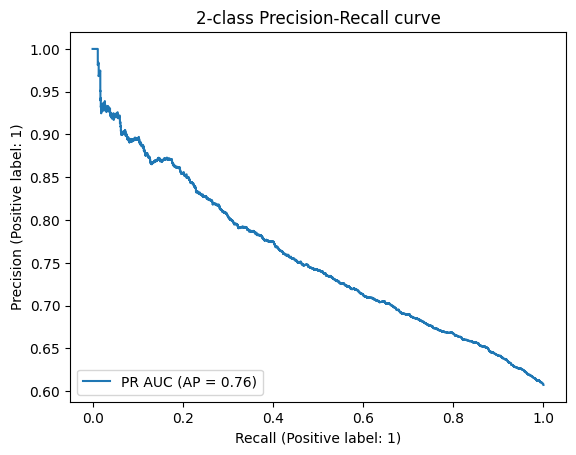

In [19]:
from sklearn.metrics import PrecisionRecallDisplay

if train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y, oof, name="PR AUC"
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")

# vol 1e6 AP=0.73

# Find the best threshold

ic| bound: 0.5, prec_score: 0.64476, obj_num: 6193, obj_pct: 0.84
ic| bound: 0.51, prec_score: 0.65167, obj_num: 6003, obj_pct: 0.81
ic| bound: 0.52, prec_score: 0.65631, obj_num: 5828, obj_pct: 0.79
ic| bound: 0.53, prec_score: 0.65987, obj_num: 5642, obj_pct: 0.76
ic| bound: 0.54, prec_score: 0.66593, obj_num: 5418, obj_pct: 0.73
ic| bound: 0.55, prec_score: 0.67005, obj_num: 5216, obj_pct: 0.7
ic| bound: 0.56, prec_score: 0.67588, obj_num: 4995, obj_pct: 0.68
ic| bound: 0.57, prec_score: 0.68352, obj_num: 4768, obj_pct: 0.64
ic| bound: 0.58, prec_score: 0.68947, obj_num: 4560, obj_pct: 0.62
ic| bound: 0.59, prec_score: 0.69851, obj_num: 4292, obj_pct: 0.58
ic| bound: 0.6, prec_score: 0.70439, obj_num: 4056, obj_pct: 0.55
ic| bound: 0.61, prec_score: 0.71073, obj_num: 3813, obj_pct: 0.52
ic| bound: 0.62, prec_score: 0.71943, obj_num: 3582, obj_pct: 0.48
ic| bound: 0.63, prec_score: 0.72977, obj_num: 3312, obj_pct: 0.45
ic| bound: 0.64, prec_score: 0.74115, obj_num: 3052, obj_pct: 0.4

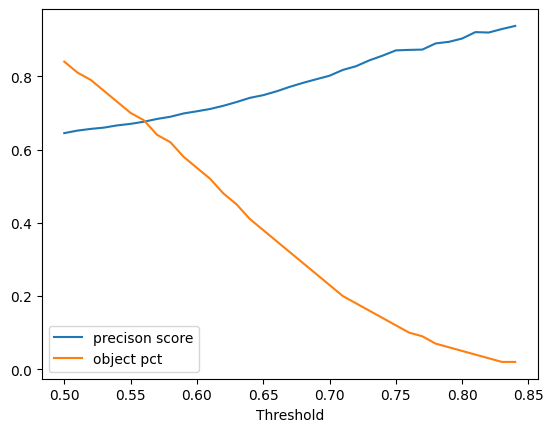

In [20]:
from icecream import ic

if train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    for hb in np.arange(0.5, 0.85, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y, oof, 1-hb, hb)
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        ic(bound, prec_score, obj_num, obj_pct)

    line1 = plt.plot(np.arange(0.5, 0.85, 0.01), prec_score_list, label='precison score')
    line2 = plt.plot(np.arange(0.5, 0.85, 0.01), obj_pct_list, label='object pct')
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

In [21]:
# vol 1e6
# ic| bound: 0.5, prec_score: 0.61839, obj_num: 11606, obj_pct: 0.78
# ic| bound: 0.51, prec_score: 0.6249, obj_num: 11213, obj_pct: 0.76
# ic| bound: 0.52, prec_score: 0.63102, obj_num: 10781, obj_pct: 0.73
# ic| bound: 0.53, prec_score: 0.63598, obj_num: 10362, obj_pct: 0.7
# ic| bound: 0.54, prec_score: 0.64185, obj_num: 9940, obj_pct: 0.67
# ic| bound: 0.55, prec_score: 0.64811, obj_num: 9500, obj_pct: 0.64
# ic| bound: 0.56, prec_score: 0.65436, obj_num: 9018, obj_pct: 0.61
# ic| bound: 0.57, prec_score: 0.6628, obj_num: 8535, obj_pct: 0.58
# ic| bound: 0.58, prec_score: 0.67065, obj_num: 8043, obj_pct: 0.54
# ic| bound: 0.59, prec_score: 0.6821, obj_num: 7518, obj_pct: 0.51
# ic| bound: 0.6, prec_score: 0.69099, obj_num: 7016, obj_pct: 0.47
# ic| bound: 0.61, prec_score: 0.703, obj_num: 6468, obj_pct: 0.44
# ic| bound: 0.62, prec_score: 0.71261, obj_num: 5985, obj_pct: 0.4
# ic| bound: 0.63, prec_score: 0.72237, obj_num: 5511, obj_pct: 0.37
# ic| bound: 0.64, prec_score: 0.73403, obj_num: 5042, obj_pct: 0.34
# ic| bound: 0.65, prec_score: 0.74404, obj_num: 4571, obj_pct: 0.31
# ic| bound: 0.66, prec_score: 0.75036, obj_num: 4146, obj_pct: 0.28
# ic| bound: 0.67, prec_score: 0.75746, obj_num: 3752, obj_pct: 0.25
# ic| bound: 0.68, prec_score: 0.77202, obj_num: 3360, obj_pct: 0.23
# ic| bound: 0.69, prec_score: 0.78097, obj_num: 2995, obj_pct: 0.2
# ic| bound: 0.7, prec_score: 0.80031, obj_num: 2594, obj_pct: 0.18
# ic| bound: 0.71, prec_score: 0.81066, obj_num: 2271, obj_pct: 0.15
# ic| bound: 0.72, prec_score: 0.82107, obj_num: 1984, obj_pct: 0.13
# ic| bound: 0.73, prec_score: 0.82911, obj_num: 1697, obj_pct: 0.11
# ic| bound: 0.74, prec_score: 0.83481, obj_num: 1465, obj_pct: 0.1
# ic| bound: 0.75, prec_score: 0.84665, obj_num: 1252, obj_pct: 0.08
# ic| bound: 0.76, prec_score: 0.85498, obj_num: 1055, obj_pct: 0.07
# ic| bound: 0.77, prec_score: 0.87159, obj_num: 880, obj_pct: 0.06
# ic| bound: 0.78, prec_score: 0.88143, obj_num: 700, obj_pct: 0.05
# ic| bound: 0.79, prec_score: 0.90248, obj_num: 564, obj_pct: 0.04
# ic| bound: 0.8, prec_score: 0.91111, obj_num: 450, obj_pct: 0.03
# ic| bound: 0.81, prec_score: 0.93043, obj_num: 345, obj_pct: 0.02
# ic| bound: 0.82, prec_score: 0.9387, obj_num: 261, obj_pct: 0.02
# ic| bound: 0.83, prec_score: 0.94258, obj_num: 209, obj_pct: 0.01
# ic| bound: 0.84, prec_score: 0.94479, obj_num: 163, obj_pct: 0.01